In [1]:
############################
### import modules

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os
from lmfit import Parameters, fit_report, minimize

###########################

np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [2]:
# read output file MC toy

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['event_tree']
    rTree_data = rTree['data_tree']
    #rTree_vuv = rTree['data_tree_vuv']
    
    event_x = np.array(rTree_event['event_x_pos'])
    event_E = np.array(rTree_event['event_E'])
    event_index = np.arange(0, len(event_E))

    data_event = np.array(rTree_data['data_event'])
    #data_pmt = np.array(rTree_data['data_pmt'])
    #data_time = np.array(rTree_data['data_time']) 

    data_index, count_scint = np.unique(data_event, return_counts=True)
    #split_pmt = np.split(data_pmt, np.cumsum(count_scint)) 
    #split_time = np.split(data_time, np.cumsum(count_scint))
    
    event_E, event_x, event_index = miss_correc(event_E, event_x, event_index, data_index)

    return event_E, event_x, event_index, data_event


def miss_correc(event_E, event_x, event_index, data_index):

########################################
# corrects for events lost, it is assumed that these are not simulated
# remember to add new event_index range, and change variable name of old event_index

    miss_index = np.setdiff1d(event_index, data_index)  #event indexes that are lost

    for element in miss_index: 
        #print(element)
        event_E = event_E[event_index != element]
        event_x = event_x[event_index != element]
        event_index = event_index[event_index != element]
        
    return event_E, event_x, event_index

fnamebase = 'events_unif.root'
fnamefoil = 'events_unif_foils.root'  

path=''

event_Ebase, event_xbase, event_indexbase, data_eventbase = root_input(path, fnamebase)
event_Efoil, event_xfoil, event_indexfoil, data_eventfoil = root_input(path, fnamefoil)

[[   0  162]
 [   1  147]
 [   2   57]
 ...
 [9997  141]
 [9998   78]
 [9999   36]]
9951
399
612
582
554
552
557
542
584
537
555
514
548
570
604
589
568
552
532
[[   0  103]
 [   1  314]
 [   2  198]
 ...
 [9997   41]
 [9998   94]
 [9999  126]]
9972
426
582
569
565
521
574
576
540
552
577
575
589
554
559
581
566
546
520
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 18
    # variables        = 4
    chi-square         = 48.8281350
    reduced chi-square = 3.48772393
    Akaike info crit   = 25.9628287
    Bayesian info crit = 29.5243157
[[Variables]]
    a:  1.5432e-06 +/- 6.6920e-08 (4.34%) (init = 0)
    b:  47.0923063 +/- 26631624.4 (56551964.63%) (init = 0)
    c: -6.0050e-04 +/- 82.1958188 (13687871.79%) (init = 0)
    d:  0.15723740 +/- 15999.3287 (10175268.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -1.000
    C(c, d) = -1.000
    C(b, c) = 1.000
    C(a, c) = -0.304
    C(a, d) = 

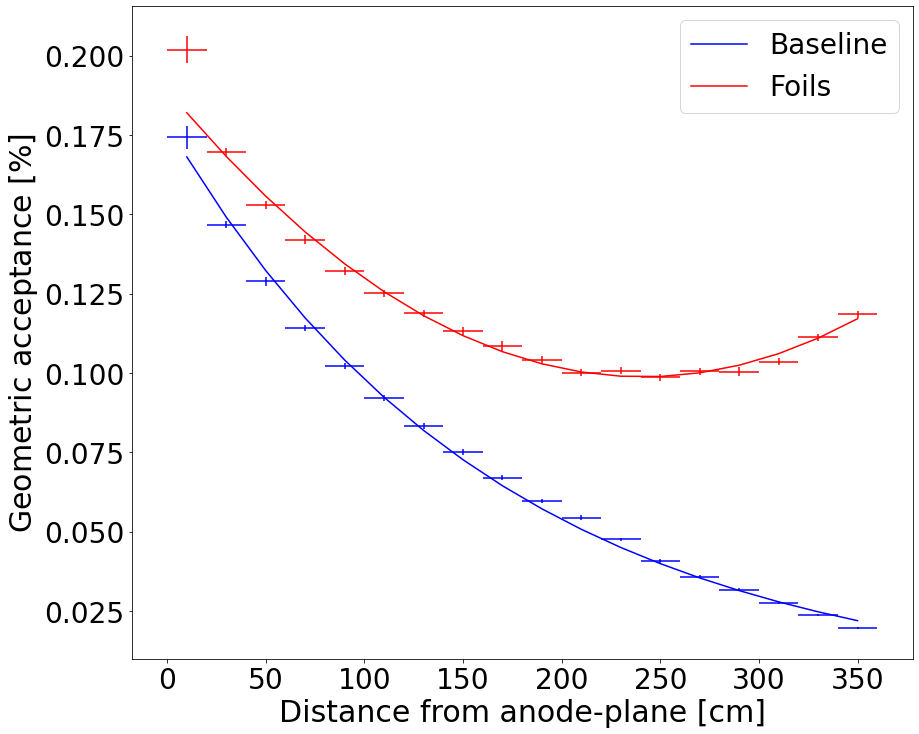

In [16]:

# scintillation in each event

def lightyield_calc(event, energy, x_pos):
    unique, counts = np.unique(event, return_counts=True)
    print(np.asarray((unique, counts)).T)
    scint_yield_true = counts / energy
    print(len(unique))
    
    bin_step = 20
    drift_size = 360
    effyield = 24000 #photons per MeV 40,000*0.6

    xbin_values = np.array([])
    err_x = bin_step/2
    bin_err_array = np.array([])

    m_SY_array = np.array([])
    err_SY = np.array([])
    

    for bin_index in range(0, int(drift_size/bin_step)):
    
        xbin_mn_edge = bin_index * bin_step
        xbin_mx_edge = (bin_index + 1) * bin_step
        xbin_avg = (xbin_mx_edge + xbin_mn_edge)/2
    
        xbin_values = np.append(xbin_values, xbin_avg)
        scint_yield = np.array([])
    
        # selecting those events that fall within our current bin
        for i in np.arange(0, len(unique)):
            if (x_pos[i] > xbin_mn_edge) & (x_pos[i] <= xbin_mx_edge):
                scint_yield = np.append(scint_yield, 100*counts[i]/(effyield*energy[i]))
        
        m_SY = np.sum(scint_yield)/len(scint_yield)
        m_SY_array = np.append(m_SY_array, m_SY)
        
        print(len(scint_yield))

        var_SY = np.sum((scint_yield - m_SY)**2)/(len(scint_yield)-1)
        err_SY = np.append(err_SY, (var_SY**0.5)/(len(scint_yield)**0.5))
    

    return xbin_values, m_SY_array, err_x, err_SY, scint_yield_true

L_xbase, L_ybase, L_errxbase, L_errybase, L_truebase = lightyield_calc(data_eventbase, event_Ebase, event_xbase)
L_xfoil, L_yfoil, L_errxfoil, L_erryfoil, L_truefoil = lightyield_calc(data_eventfoil, event_Efoil, event_xfoil)


#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def exp(x, a, b, c):
    return a * np.exp(-b * (x- c))

def quadratic(x, a, b, c, d):
    return a*(x-b)**2 + c*(x-b) + d


def residual(params, x, data, uncertainty):
    a = params['a']
    b = params['b']
    c = params['c']
    d = params['d']

    model = quadratic(x, a, b, c, d)

    return (data - model) / uncertainty

params = Parameters()
params.add('a', value=0)
params.add('b', value=0)
params.add('c', value=0)
params.add('d', value=0)

out = minimize(residual, params, args=(L_xfoil, L_yfoil, L_erryfoil))
print(fit_report(out))

params = np.array([])
#print('Parameter, Value, Stderr')
for name, param in out.params.items():
    params = np.append(params, param)
    #print(name, param.value, param.stderr)


print(params)

paramsbase = [1.40028568e-01, 5.99325389e-03, 4.04727425e+01]
paramsfoil = [1.55437057e-06,  0.00000000e+00, -7.50520309e-04,  1.89349184e-01]


plt.figure(figsize=(14,12))

#plt.scatter(L_xbase, L_ybase, s = 30, marker='x', color='blue')
#plt.scatter(L_xfoil, L_yfoil, s = 30, marker='x', color='red')

plt.plot(L_xbase, exp(L_xbase, *paramsbase), color='blue', label='Baseline')
plt.plot(L_xfoil, quadratic(L_xfoil, *paramsfoil), color='red', label='Foils')

plt.errorbar(L_xbase, L_ybase, xerr=L_errxbase, yerr=L_errybase, marker='', color='blue', ls='none')
plt.errorbar(L_xfoil, L_yfoil, xerr=L_errxfoil, yerr=L_erryfoil, marker='', color='red', ls='none')
    
plt.xlabel('Distance from anode-plane [cm]',fontsize=30)
plt.ylabel('Geometric acceptance [$\%$]',fontsize=30)
    
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)

plt.savefig('../figures/eff_config.png', bbox_inches='tight')

plt.show()
    